# Modelo para auxilio no diagnóstico de Pneumunia.

  O modelo utiliza a DenseNet201 classidicando a imagem com "Normal", "Pneumunia Bacteriana" ou "Pneumunia Viral".


## Importando e carregando bibliotecas básica

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import paths

## Criação da constantes do modelo

In [ ]:
INIT_LR = 1e-3
EPOCHS = 20
BS = 50
np.random.seed(0)

## Carrega e tratamento inicial do dataset


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
workdir_path = '/content/drive/My Drive/TCC_IMAGENS'
os.chdir(workdir_path)

Mounted at /content/drive


In [ ]:
from imutils import paths

dataset_path = 'dataset_imagens'
imagens_raioX  = list(paths.list_images(dataset_path))


In [ ]:
#Tratamento das imagens, criação e carga das listas de imagens e labels
import cv2

imagens = []
labels = []

for imagem in imagens_raioX:

    label = imagem.split(os.path.sep)[-2]

   # Faz tratemento nos canais de cores das imagens e padroniza
   # o tamnho em 224 x 224
    imagem = cv2.imread(imagem)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    imagem = cv2.resize(imagem, (224, 224))

    imagens.append(imagem)
    labels.append(label)

## Análise exploratória

### Verificando o balanceomento do dataset

In [ ]:
# Criua e carrega os dados quantitaivis da lista de imagens em um
# dicionario de dados para análise quantitativa das imagens

import matplotlib.pyplot as plt

dados = {'NORMAL': labels.count('NORMAL'), 'PNEUMONIA_BACTERIANA':labels.count('PNEUMONIA_BACTERIANA'), 'PNEUMONIA_VIRAL':labels.count('PNEUMONIA_VIRAL') }
plt.figure()
plt.bar(dados.keys(), dados.values())
plt.show()



### Preparando e visualizando imagem

In [ ]:
# Converte as lista em matrizes, padronizando a escala de pixel na escala de
# [0, 255]

imagens_N = np.array(imagens) / 255.0
labels_N = np.array(labels)


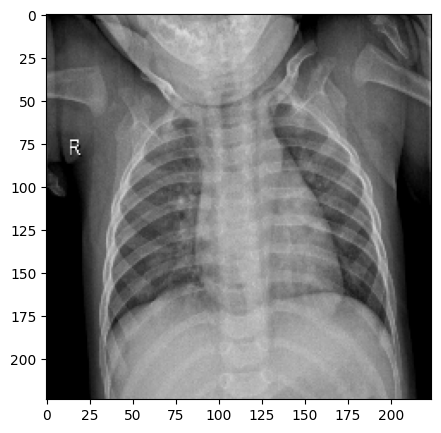

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(imagens_N[labels_N =='NORMAL'][1])
plt.show()

## Transformando os labels para numeral

In [ ]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

lb = LabelBinarizer()
labels_b = lb.fit_transform(labels_N)

### Separação dos dados de treino, teste.

In [ ]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(imagens_N, labels_b, test_size=0.20, stratify=labels_b, random_state=42)

## Rede Neural



### Importando e configurando a rede VGG16

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input

baseModel = DenseNet201 (weights="imagenet", include_top=False,
                  input_tensor = Input(shape=(224, 224, 3)))

### Definindo a camadade Saida FC

In [ ]:
# Construindo a camada FC
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(3, activation="softmax")(headModel)


### Montado a rede

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

### Carregando e compilando o modelo

In [ ]:
from tensorflow.keras.optimizers import Adam

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compilando o modelo...")
opt = Adam(learning_rate=INIT_LR, weight_decay=INIT_LR / EPOCHS )
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

### Verificando as saída da camada convolucional

In [ ]:
#baseModel = InceptionV3(weights="imagenet", include_top=False,
                  #input_tensor=Input(shape=(224, 224, 3)))

f1 = baseModel.layers[1].output
f2 = baseModel.layers[2].output
f3 = baseModel.layers[4].output
f4 = baseModel.layers[5].output
feature_maps = Model(inputs=baseModel.input, outputs=[f1, f2, f3, f4])

In [ ]:
y = np.argmax(trainY, axis=-1)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D

feat1, feat2, feat3, feat4 = feature_maps.predict(trainX[y==1][0:1])

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(feat1[0, :, :, 0:3])
axs[0, 1].imshow(feat2[0, :, :, 6:9])
axs[1, 0].imshow(feat3[0, :, :, 0:3])
axs[1, 1].imshow(feat4[0, :, :, 3:6])
plt.show()

### Trainando a FC

In [ ]:
print("[INFO] Trainando a FC...")
h = model.fit(trainX,
              trainY,
              batch_size = BS,
              steps_per_epoch=len(trainX) // BS,
              validation_split=0.2,
              epochs=EPOCHS)

## Analisando a performance do modelo

In [ ]:
score = model.evaluate(testX, testY, verbose=0)

print('Test accuracy:', score[1])

In [ ]:
h.history.keys()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("[INFO] Avaliando a Rede...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])


### Gráficos: Loss, Accuracy e validação

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='train')
plt.plot(h.history['val_loss'], label='valid')
plt.title("Loss no treino Pneumunia Dataset")
plt.ylabel('loss')
plt.xlabel('época')
plt.legend()
plt.show()

In [ ]:
plt.plot(h.history['accuracy'], label='train')
plt.plot(h.history['val_accuracy'], label='validation')
plt.title("Acurácia no treino Pneumunia Dataset")
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt=".0f", cmap='YlGnBu')
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Matriz de Confusão')

# Colocar os nomes
ax.xaxis.set_ticklabels(['Normal', 'Bacteriana','Viral'])
ax.yaxis.set_ticklabels(['Normal', 'Bacteriana','Viral'])
plt.show()